#  スパッタリング率のプロット

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
path2data = "/Users/y1u0d2/Downloads"
# path2data = "/Users/y1u0d2/Google Drive/マイドライブ/HamaLab_kotani/sputtering"
data_filename = "sp.xlsx"
# sheet_name = "si_self_substrate_size"
sheet_name = "si_self_all_in"

In [8]:
# read excel file
sy_df = pd.read_excel(os.path.join(path2data, data_filename), sheet_name=sheet_name)

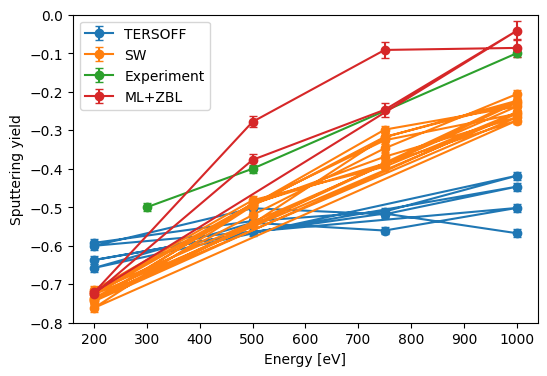

In [9]:
# スパッタリング率のプロット
fig, ax = plt.subplots(figsize=(6, 4))

# for height in sy_df["height"].unique():
#     ax.plot(
#         sy_df[sy_df["height"] == height]["energy"],
#         sy_df[sy_df["height"] == height]["sy_depo_ion_dose"],
#         marker="o",
#         label=f"TERSOFF-{height}",
#     )
for calculation_type in sy_df["potential"].unique():
    # ax.plot(
    #     sy_df[sy_df["potential"] == calculation_type]["energy"],
    #     sy_df[sy_df["potential"] == calculation_type]["sy_depo_ion_dose"],
    #     marker="o",
    #     label=f"{calculation_type}",
    # )
    # plot error bar upper is upper_sy and lower is lower_sy
    ax.errorbar(
        sy_df[sy_df["potential"] == calculation_type]["energy"],
        sy_df[sy_df["potential"] == calculation_type]["sy_depo_ion_dose"],
        yerr=[
            sy_df[sy_df["potential"] == calculation_type]["sy_depo_ion_dose"] - sy_df[sy_df["potential"] == calculation_type]["lower_sy"],
            sy_df[sy_df["potential"] == calculation_type]["upper_sy"] - sy_df[sy_df["potential"] == calculation_type]["sy_depo_ion_dose"],
        ],
        capsize=3,
        marker="o",
        label=f"{calculation_type}",
    )
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")
ax.set_ylim(-0.8, 0.0)
ax.legend()

In [5]:
sy_ml_df = pd.read_excel(os.path.join(path2data, data_filename), sheet_name="si_self_ml")

In [22]:
sy_ml_df = sy_ml_df.sort_values(by="energy").reset_index(drop=True)

In [23]:
sy_ml_df

,potential,energy,sy_ion_dose,sy_depo_ion_dose
0,ML+ZBL(without amorphous),100,0.097629,-0.909833
1,ML+ZBL(without amorphous),200,0.339994,-0.646803
2,ML+ZBL(amorohous: 12308),200,0.585136,-0.414864
3,ML+ZBL(amorohous: 2486),200,0.591348,-0.408652
4,ML+ZBL(amorohous: 676),200,0.430367,-0.569633
5,ML+ZBL(amorohous: 2486),500,1.101789,0.101789
6,ML+ZBL(amorohous: 12308),500,1.114288,0.114288
7,ML+ZBL(without amorphous),500,0.695030,-0.340113
8,ML+ZBL(amorohous: 676),500,0.823466,-0.176534
9,ML+ZBL(amorohous: 676),750,1.012135,0.012135


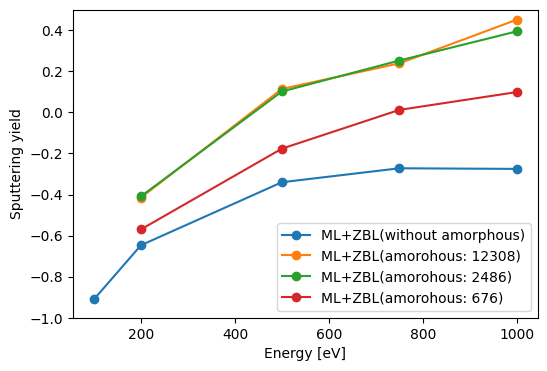

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
for calculation_type in sy_ml_df["potential"].unique():
    ax.plot(
        sy_ml_df[sy_ml_df["potential"] == calculation_type]["energy"],
        sy_ml_df[sy_ml_df["potential"] == calculation_type]["sy_depo_ion_dose"],
        marker="o",
        label=f"{calculation_type}",
    )
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")
ax.set_ylim(-1.0, 0.5)
ax.legend()

## 古典ポテンシャルとMLを同時にプロット

In [25]:
sy_df_concat = pd.concat([sy_df, sy_ml_df], axis=0)

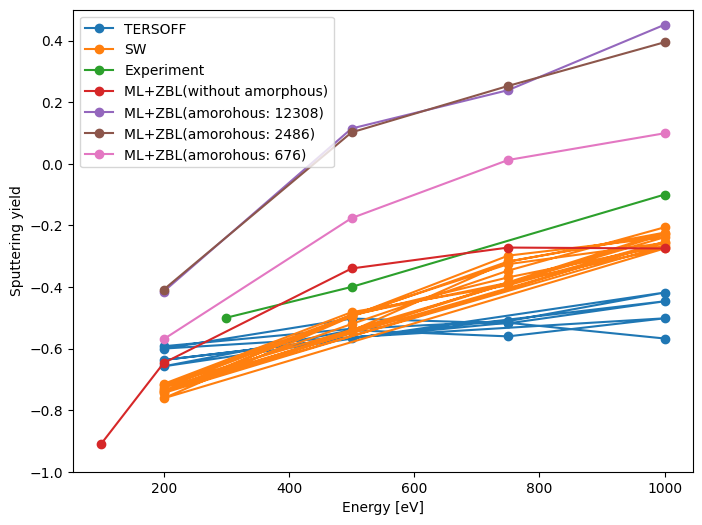

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
for calculation_type in sy_df_concat["potential"].unique():
    ax.plot(
        sy_df_concat[sy_df_concat["potential"] == calculation_type]["energy"],
        sy_df_concat[sy_df_concat["potential"] == calculation_type]["sy_depo_ion_dose"],
        marker="o",
        label=f"{calculation_type}",
    )
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Sputtering yield")
ax.set_ylim(-1.0, 0.5)
ax.legend()

In [ ]:
from glob import glob
import os

path2relax = "/home/y1u0d2/result/qe/Si/amorphous/relax/result"
relax_dir_list = glob(os.path.join(path2relax, "relax_*"))

all_scf_calculation_count = 0
for relax_dir in relax_dir_list:
    path2target = os.path.join(relax_dir, "relax.out")
    if not os.path.exists(path2target):
        continue

    with open(path2target, "r") as f:
        lines = [s.strip() for s in f.readlines()]
    
    # search ! in lines
    scf_calculation_count = 0
    is_job_done = False
    for i, line in enumerate(lines):
        if "!" in line:
            scf_calculation_count += 1
        if "convergence NOT achieved" in line:
            break
        if "JOB DONE" in line:
            is_job_done = True
            break
    if not is_job_done:
        continue

    all_scf_calculation_count += scf_calculation_count
    print(f"relax_dir: {relax_dir} has {scf_calculation_count} scf calculation")

print(f"all_scf_calculation_count: {all_scf_calculation_count}")